# Data Preparation

### Imports

In [29]:
# Import Python modules
import pandas as pd
from pandas import Series, DataFrame, MultiIndex
import numpy as np
from datetime import datetime
from datetime import timedelta 
import timeit
import csv
import matplotlib 
import matplotlib.pyplot as plt
import random
import time

### Data Cleaning, Reduction and Transformation

In [32]:
start_time = time.time()

# Case 1: Import an existing household-ID-sample
# sample_ids = pd.read_pickle('Sample_IDs_n=5000.pkl')['IDs'].tolist()
sample_ids = pd.read_pickle('Simulation_IDs.pkl').to_numpy(dtype='float64')
n = len(sample_ids)

# Case 2: Create, save and continue with a new household-ID-sample
# n = 15000
# sample_ids = random.sample(pd.read_pickle('All_IDs.pkl')['IDs'].tolist(), n)
# pd.DataFrame(data=sample_ids, columns=['IDs']).to_pickle('Sample_IDs_n={}.pkl'.format(n))

# Create an empty list to store the DataFrames of all months and concat them after the list is filled 
households_all_months = []

# Start the data cleaning process for all months
for month in range(1,13):
    
    # Import the full household data of the current month
    month_str = "0" + str(month) if (month<10) else str(month) 
    households_total = pd.read_pickle("ChicagoHouseholds\\{}_consumptionReformatted".format(month_str))

    # Construct a data sample including only the households with the pre-determined sample-IDs
    households_sample = households_total[households_total['accountIdentifier'].isin(sample_ids)].copy()

    # Temporarily replace the '2400'-time-values with '2359' to enable the creation of preliminary datetime-objects
    households_sample.time.replace('hr2400', 'hr2359', inplace=True)

    # Before the date-values are transformed, save the value of the month's first day in the old format (170XX),
    # so that it can be used to calculate the current day from the old format later
    old_value = int(households_sample[:1]['date']) - 1

    # Join the date- and time-values to get a unique 'date+time'-value for each time step, to enable a pivot-table 
    households_sample['date'] = households_sample['date'].astype(str) + households_sample['time'].astype(str)

    # Create a pivot table to generate a clean, redundancy-free time series and reduce storage consumption
    # rows = time steps, columns = household-IDs, entries = consumption for each household-ID at each time step
    households = households_sample.pivot(index='date', columns='accountIdentifier', values='hh_consumption')
    
    # Drop redundant time values ('24:30' and '25:00') from the pivot table
    redundant_values = [index for index in households.index.array if ('2430' in index) | ('2500' in index)]
    households.drop(redundant_values, inplace=True)

    # Transform the 'date+time'-values into functional datetime-objects
    households.index = households.index.map(lambda date : datetime.strptime(str(int(date[:5])-old_value) + '-{}-2016-'.format(month) + date[9:11] + '-' + date[11:13], '%d-%m-%Y-%H-%M'))

    # Correct the '24:00h-problem': replace all '24:00h'-values of day x with '00:00h'-values of day x+1
    index_cleaned = []
    for dt in households.index:
            if(dt.minute==59):
                dt = dt + timedelta(days=1)
                dt = dt.replace(hour=0, minute=0)
            index_cleaned.append(dt)
    households.index = index_cleaned
    
    # Sort the data by columns-label so that the columns are in identical order for concatenation
    # Using Mergesort, since it is the only stable sorting algorithm
    households.sort_index(axis='columns', inplace=True, kind='mergesort')
    
    # Save the cleaned data for the current month in a seperate file 
#     households.to_pickle('ChicagoHouseholds_Cleaned/households_cleaned_{}_n={}'.format(month, n))
    
    # Add the cleaned data for the current month to the list containing the DataFrames of all months
    households_all_months.append(households)

    print("Month Nr. {} finished".format(month))

# Concatenate the list of DataFrames to create a single DataFrame containing the data for the whole year
households_2016 = pd.concat(households_all_months, axis='rows')

# Create a Multi-Index with day and time to simplify grouping by day
date_indexes = []
time_indexes = []
for i in households_2016.index:
    date_indexes.append(datetime.strptime('{}-{}-{}'.format(i.year, i.month, i.day),'%Y-%m-%d'))
    time_indexes.append(i)
households_2016.index = pd.MultiIndex.from_arrays([date_indexes, time_indexes], names=['Day', 'Time'])

# Rename the column-axis
households_2016.columns.rename(name='Household-IDs', inplace=True)

# Save the final data
households_2016.to_pickle('households_cleaned_2016_simulation.pkl')

print("All months finished")
print('Calculation Runtime: {:.2} Minutes'.format((time.time() - start_time)/60))

Month Nr. 1 finished
Month Nr. 2 finished
Month Nr. 3 finished
Month Nr. 4 finished
Month Nr. 5 finished
Month Nr. 6 finished
Month Nr. 7 finished
Month Nr. 8 finished
Month Nr. 9 finished
Month Nr. 10 finished
Month Nr. 11 finished
Month Nr. 12 finished
All months finished
Calculation Runtime: 1.5e+01 Minutes


### Normalization

In [45]:
households = pd.read_pickle('households_cleaned_2016_simulation.pkl')
households_sum = households.sum(axis='index')

(households / households_sum).to_pickle('households_cleaned_2016_simulation_normalized.pkl')

# Data Analysis

### Imports

In [1]:
# Import Python modules
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

# Specify n (Currently: 5000, 10000 or 15000)
n = 5000
# Specify if normalized data should be loaded or not
normalized = "_normalized"

# Import the cleaned data file
households = pd.read_pickle('ChicagoHouseholds_Cleaned/households_cleaned_2016_n={}{}'.format(n, normalized))

print("Imports finished")

Imports finished


### Visualisation

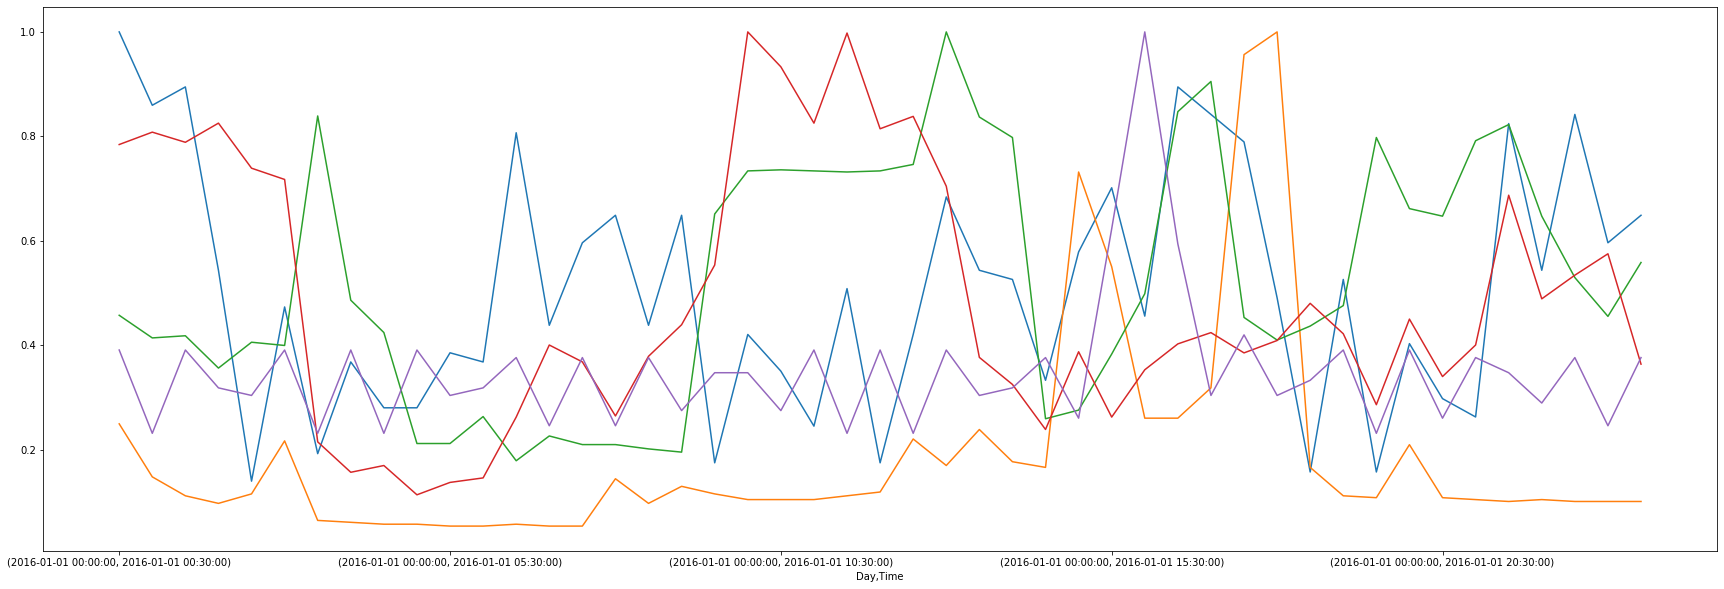

In [2]:
day_1 = households.iloc[households.index.get_level_values('Day') == '2016-01-01', :5]
day_1.plot.line(figsize=(30,10), legend=False)

### Mean Daily Consumption

In [9]:
# Get the each households's daily consumption 
households_daily_sums = households.groupby(level='Day').sum()
households_daily_sums_mean = households_daily_sums.mean(axis='rows')
households_daily_sums_mean.describe()

# -> The households could be characterized by their mean daily consumption:
# c <= 9.5: low mean daily consumption
# 9.5 < c < 22.0: medium mean daily consumption
# c >= 22.0: high mean daily consumption

count    5000.000000
mean       21.104188
std         4.716828
min         5.702335
25%        18.133992
50%        21.205907
75%        23.996254
max        44.142078
dtype: float64

Text(0, 0.5, 'Frequency')

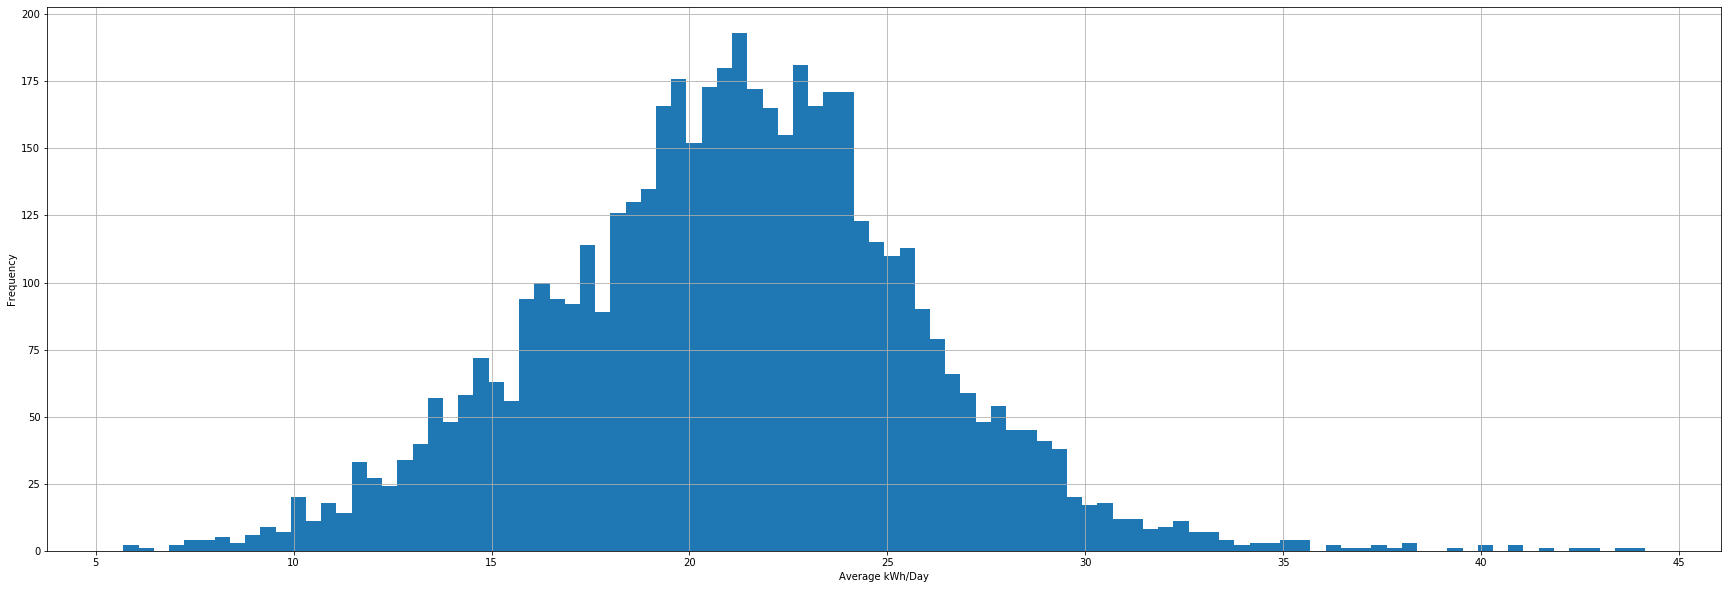

In [12]:
# Show the distribution of the mean daily consumption values of the sample
distr = households_daily_sums_mean.hist(figsize=(30,10), bins=100)
distr.set_xlabel('Average kWh/Day')
distr.set_ylabel('Frequency')

### Load Shape Indices 
Reference: Source [5] (Data Mining techniques application in Power Distribution utilities)

In [5]:
# Prepare the data subsets that are required for the calculation of the Load Shape Indices
hh_mean = households.groupby(level='Day').mean()
hh_max = households.groupby(level='Day').max()
hh_min = households.groupby(level='Day').min()
hh_mean_night = households[households.index.get_level_values('Time').hour.isin([23,0,1,2,3,4,5,6])].groupby(level='Day').mean()
hh_mean_lunch = households[households.index.get_level_values('Time').hour.isin([12, 13])].groupby(level='Day').mean()
# hh_day = households.drop(hh_night.index.get_level_values('Time'), level='Time').copy()

# Calculate the Load Shape Indices
av_max = (hh_mean / hh_max).mean(axis='rows') # Load Factor
min_max = (hh_min / hh_max).mean(axis='rows') # Non-uniformity Coefficient
min_av = (hh_min / hh_max).mean(axis='rows')
night_impact = ((1/3) * (hh_mean_night / hh_mean)).mean(axis='rows')
lunch_impact = ((1/8) * (hh_mean_lunch / hh_mean)).mean(axis='rows')

# Merge the Load Shape Indices into a DataFrame
values = [av_max, min_max, min_av, night_impact, lunch_impact]
index_labels = ['P(av)/P(max)', 'P(min)/P(max)', 'P(min)/P(av)', 'Night Impact', 'Lunch Impact']
load_shape_indices = pd.DataFrame(values, index_labels)
load_shape_indices.index.rename(name='Load Shape Indices', inplace=True)
load_shape_indices.columns.rename(name='Household-IDs', inplace=True)

# Save the completed Load Shape Indices
load_shape_indices.to_pickle('Load_Shape_Indices_n={}_normalized'.format(n))

load_shape_indices

Household-IDs,1.000598e+15,1.000603e+15,1.000638e+15,1.000640e+15,1.000653e+15,1.000598e+16,1.000599e+16,1.000601e+16,1.000602e+16,1.000602e+16,...,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000657e+18,1.000664e+18
Load Shape Indices,,,,,,,,,,,,,,,,,,,,,
P(av)/P(max),0.488798,0.381215,0.531853,0.475685,0.323568,0.446313,0.492067,0.489225,0.551347,0.365237,...,0.472163,0.361767,0.516967,0.345626,0.495279,0.372815,0.414720,0.523399,0.339695,0.463889
P(min)/P(max),0.140212,0.205009,0.231540,0.165814,0.091709,0.136093,0.271046,0.149050,0.231548,0.113610,...,0.312898,0.086729,0.192936,0.105556,0.204333,0.037510,0.172188,0.265504,0.052702,0.197522
P(min)/P(av),0.140212,0.205009,0.231540,0.165814,0.091709,0.136093,0.271046,0.149050,0.231548,0.113610,...,0.312898,0.086729,0.192936,0.105556,0.204333,0.037510,0.172188,0.265504,0.052702,0.197522
Night Impact,0.355001,0.308890,0.309095,0.215351,0.198879,0.265488,0.314805,0.235325,0.331962,0.265817,...,0.288784,0.279243,0.333084,0.220786,0.309550,0.276529,0.245168,0.310598,0.292267,0.329229
Lunch Impact,0.096952,0.120391,0.131109,0.139027,0.144878,0.129488,0.113081,0.129237,0.108289,0.124963,...,0.117007,0.130655,0.095447,0.120984,0.123874,0.102455,0.144723,0.125264,0.090756,0.127171


In [3]:
import pandas as pd
load_shape_indices = pd.read_pickle('Load_Shape_Indices_n=5000_normalized')

load_shape_indices
# Plot the distribution of Load Shape Factors
# load_shape_indices.T.hist(layout=(5,1), bins=100, figsize=(20,20), sharex=True)

Household-IDs,1.000598e+15,1.000603e+15,1.000638e+15,1.000640e+15,1.000653e+15,1.000598e+16,1.000599e+16,1.000601e+16,1.000602e+16,1.000602e+16,...,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000656e+18,1.000657e+18,1.000664e+18
Load Shape Indices,,,,,,,,,,,,,,,,,,,,,
P(av)/P(max),0.488798,0.381215,0.531853,0.475685,0.323568,0.446313,0.492067,0.489225,0.551347,0.365237,...,0.472163,0.361767,0.516967,0.345626,0.495279,0.372815,0.414720,0.523399,0.339695,0.463889
P(min)/P(max),0.140212,0.205009,0.231540,0.165814,0.091709,0.136093,0.271046,0.149050,0.231548,0.113610,...,0.312898,0.086729,0.192936,0.105556,0.204333,0.037510,0.172188,0.265504,0.052702,0.197522
P(min)/P(av),0.140212,0.205009,0.231540,0.165814,0.091709,0.136093,0.271046,0.149050,0.231548,0.113610,...,0.312898,0.086729,0.192936,0.105556,0.204333,0.037510,0.172188,0.265504,0.052702,0.197522
Night Impact,0.355001,0.308890,0.309095,0.215351,0.198879,0.265488,0.314805,0.235325,0.331962,0.265817,...,0.288784,0.279243,0.333084,0.220786,0.309550,0.276529,0.245168,0.310598,0.292267,0.329229
Lunch Impact,0.096952,0.120391,0.131109,0.139027,0.144878,0.129488,0.113081,0.129237,0.108289,0.124963,...,0.117007,0.130655,0.095447,0.120984,0.123874,0.102455,0.144723,0.125264,0.090756,0.127171


In [7]:
# Basic statistical analysis of the Load Shape Factors
load_shape_indices.T.describe()

Load Shape Indices,P(av)/P(max),P(min)/P(max),P(min)/P(av),Night Impact,Lunch Impact
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.442365,0.186760,0.186760,0.290310,0.118670
std,0.098274,0.092406,0.092406,0.050756,0.020062
min,0.121475,0.000741,0.000741,0.012392,0.000968
25%,0.380485,0.123330,0.123330,0.257906,0.106773
50%,0.444489,0.174688,0.174688,0.289190,0.118416
75%,0.502616,0.234826,0.234826,0.321536,0.129392
max,0.922346,0.813122,0.813122,0.625343,0.274277


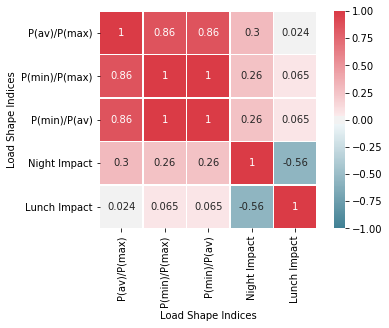

In [10]:
# sns.pairplot(load_shape_indices.T, kind='reg')
sns.heatmap(load_shape_indices.T.corr(),
            square=True,
            linewidths=.5, 
            vmin=-1.0,
            vmax=1.0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            annot=True)

In [60]:
load_shape_indices.T[load_shape_indices.T['Night Impact'] >= 0.4]['Night Impact'].count()

115

25% der Haushalte haben einen Night Impact zwischen 32% und 62% -> Könnte auf E-Autos hindeuten?

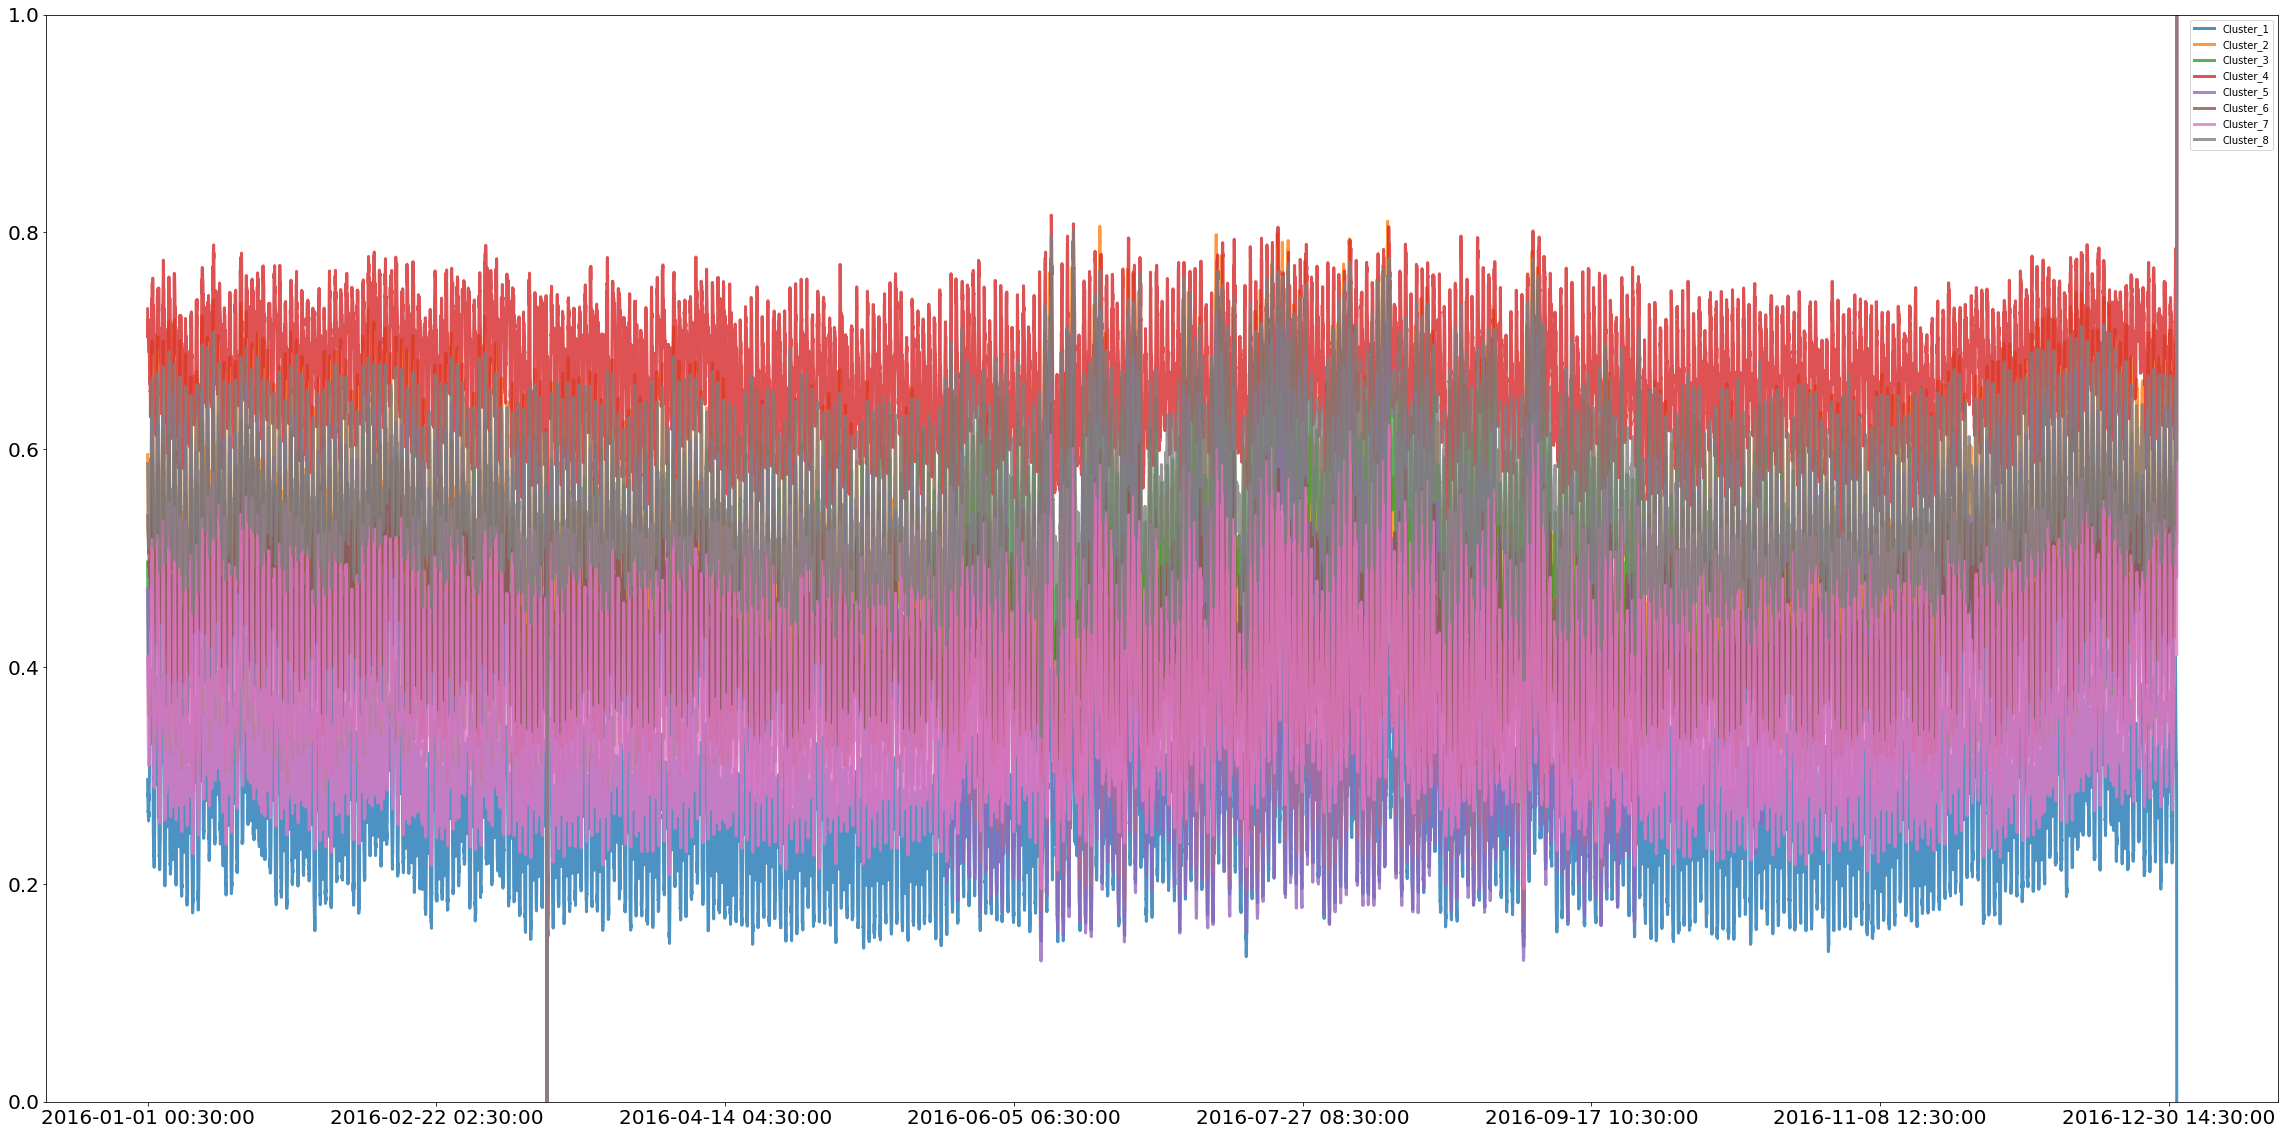

In [23]:
from matplotlib import pyplot as plt

kmeans_8.plot.line(alpha=0.8, lw=3, figsize=(40,20), fontsize=20, ylim=(0,1))

# Für später: Subset der Haushalte

In [ ]:
# reads csv-sampleFile into dictionary
# handles data conversion problems (Zahlen wurden bei dict-csv-dict conversion falsch wieder eingelesen, daraufhin konnten manche IDs nicht gefunden werden)
# Output: Dictionary with household samples from csv
# Erklärung output: Jeder dictionary Eintag steht für eine Community und enthät eine Liste mit 5 IDs. 
## Die erste und zweite ID waren in der Simulation PV- und Batteriebesitzer. Die dritte ID nur PV Besitzer. Die 4. und 5. ID reine Konsumenten.

def read_household_samples():
    with open('household.sample.csv', 'r') as csvFile:
        d = {}
        reader = csv.reader(csvFile)
        for row in reader:
            k = row
            d[int(k[0])]= k[1:6]
        
        for key in d.keys():
            d[key] = [x.replace("[","") for x in d[key]]
            d[key] = [x.replace("]","") for x in d[key]]
            d[key] = [ float(x) for x in d[key] ]
            d[key] =[ int(x) for x in d[key] ]
    return d        
    csvFile.close()

In [ ]:
# Reverse Operation: save a dictionary in csv file 
# Schreibt jeden EIntrag des Dictionaies in eine neue Zeile der CSV Datei
with open('NameOfYourCSV.csv', 'w') as f:
    for key in dictionary.keys():
        f.write("%s,%s\n"%(key,dictionary[key]))  

In [ ]:
# Input: Dictionary of n sets of a number of households; c = Consumption DataFrame; number = # of hh per set (default = 5)
# Output: subset of Consumption DataFrame containing only the households from sample dictionary
def get_consumption_data(sample_dict, c = pd.DataFrame(), number = 5):
    
    l = []
    for key in sample_dict:
        for i in range(0,number):
            l.append(sample_dict[key][i])
    
    hh_con = c[c["accountIdentifier"].isin(l)]
    return hh_con